In [166]:
import warnings
import pandas as pd 
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import SnowballStemmer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import gensim.corpora as corpora
from gensim import models
from gensim.models.coherencemodel import CoherenceModel 
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import os
from sklearn.model_selection import cross_val_score


[nltk_data] Downloading package punkt to /Users/xinyuliu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/xinyuliu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [139]:
#your work should only start with the following code
df = pd.read_csv('A2_Data.csv',index_col=[0],parse_dates = ['date'])
df['Month'] = df['date'].dt.month
df['Year'] = df['date'].dt.year
df['Hour'] = df['date'].dt.hour
df.head(1)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,tweet_source,user_days_on_twitter,RiseFall,Month,Year,Hour
0,Digital Shogun ပωပ 🛡🌐⚔,Rings of Saturn,Non-Binary🏳️‍🌈Metaverse Builder. Web3 Content ...,19/01/2021 10:54,4082,221,59613,False,2022-11-01 17:11:00,"Another decent bounce for #Bitcoin $BTC\n\n1w,...","['Bitcoin', 'HODL']",Twitter for Android,357,Equal,11,2022,17


# Text preparation

In [140]:
#Ignore warnings for clearer report.
warnings.filterwarnings("ignore")

In [141]:
#remove null value
df = df.dropna()

In [142]:
#convert RiseFall label
df['RiseFall'].replace('Rise',1,inplace = True)
df['RiseFall'].replace('Fall',-1,inplace = True)
df['RiseFall'].replace('Equal',0,inplace = True)
df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,tweet_source,user_days_on_twitter,RiseFall,Month,Year,Hour
0,Digital Shogun ပωပ 🛡🌐⚔,Rings of Saturn,Non-Binary🏳️‍🌈Metaverse Builder. Web3 Content ...,19/01/2021 10:54,4082,221,59613,False,2022-11-01 17:11:00,"Another decent bounce for #Bitcoin $BTC\n\n1w,...","['Bitcoin', 'HODL']",Twitter for Android,357,0,11,2022,17
1,Conor Okus,Global,Making #Bitcoin more than an investment @spira...,16/01/2012 20:55,3771,439,11363,False,2022-11-01 17:11:00,Heads up! I'll be going live this Thursday at ...,['Bitcoin'],Twitter Web App,3647,0,11,2022,17
2,Dr. Crypto Jones,"Atlanta, GA",I am NOT a financial advisor. I AM a cryptocur...,21/03/2021 1:27,19,109,132,False,2022-11-01 17:11:00,"Not too much, but 2022 be good to me baby! Bin...","['NFT', 'Ethereum', 'Bitcoin']",Twitter for Android,296,0,11,2022,17
3,Crypto Rover 🧙‍♂️,Bitcoin 🤩🌙,🎥 YouTube: Crypto Rover with daily technical a...,24/01/2021 16:50,53920,241,13165,False,2022-11-01 17:11:00,#BITCOIN HERE WE GO!! https://t.co/9HgSsh1qsD,['BITCOIN'],Twitter Web App,352,0,11,2022,17
4,Simon 🎈,"Maryland, USA","PSB Advanced Technology, LLC CTO ""Bridge the G...",24/04/2020 20:05,1443,2420,10527,False,2022-11-01 17:11:00,https://t.co/KUBQR8cz2k FutureSELF Collection ...,"['iot', 'crypto', 'fashion', 'shirts', 'future...",Twitter Web App,626,0,11,2022,17


In [143]:
#including necessary attributes
df1 = df.drop(columns=['user_name','user_location','user_description','date','user_created','user_verified','hashtags','tweet_source'])
df1.head()

,user_followers,user_friends,user_favourites,text,user_days_on_twitter,RiseFall,Month,Year,Hour
0,4082,221,59613,"Another decent bounce for #Bitcoin $BTC\n\n1w,...",357,0,11,2022,17
1,3771,439,11363,Heads up! I'll be going live this Thursday at ...,3647,0,11,2022,17
2,19,109,132,"Not too much, but 2022 be good to me baby! Bin...",296,0,11,2022,17
3,53920,241,13165,#BITCOIN HERE WE GO!! https://t.co/9HgSsh1qsD,352,0,11,2022,17
4,1443,2420,10527,https://t.co/KUBQR8cz2k FutureSELF Collection ...,626,0,11,2022,17


In [144]:
#removing punctuations to reduce noise
df1["text"].replace({r'[^\w\s]+': ''}, regex=True, inplace =True)

In [145]:
#tokenising
df2 = df1['text'].apply(word_tokenize)

In [146]:
#Case Folding
df3 = df2.apply(lambda x: [word.lower() for word in x])

In [147]:
#Stopwords Removal - Storing the stopwords into a list.
My_stop_words = stopwords.words("English")

In [148]:
#Stopwords removal for each words on the Reviews attribute and keep only words/tokens that is not in the dictionary.
#After the stopwords removal, we store it into a new dataframe. 
df4 = df3.apply(lambda x: [word for word in x if word not in My_stop_words])  

In [149]:
#Stemming - Storing the stemmer words for English language into a list.
My_stemmer = SnowballStemmer("english")

In [150]:
#Stemming for each words on the Reviews attribute.
#After the Stemming process is done, we store it into a new dataframe
df5 = df4.apply(lambda x:[My_stemmer.stem(word) for word in x])

In [151]:
#Enriching data
#The content of df is in the form of List. 
#we need to convert list to string as some of the functions work with strings.
df6 = df5.apply(lambda x:" ".join(x))

In [152]:
df_enriched=df1

In [153]:
df_enriched["Processed_text"]=df6

In [154]:
df_enriched

,user_followers,user_friends,user_favourites,text,user_days_on_twitter,RiseFall,Month,Year,Hour,Processed_text
0,4082,221,59613,Another decent bounce for Bitcoin BTC\n\n1w 1d...,357,0,11,2022,17,anoth decent bounc bitcoin btc 1w 1d 8hr id sa...
1,3771,439,11363,Heads up Ill be going live this Thursday at 18...,3647,0,11,2022,17,head ill go live thursday 1830 utc glozow shel...
2,19,109,132,Not too much but 2022 be good to me baby Bing ...,296,0,11,2022,17,much 2022 good babi bing bong nft ethereum bit...
3,53920,241,13165,BITCOIN HERE WE GO httpstco9HgSsh1qsD,352,0,11,2022,17,bitcoin go httpstco9hgssh1qsd
4,1443,2420,10527,httpstcoKUBQR8cz2k FutureSELF Collection Sear...,626,0,11,2022,17,httpstcokubqr8cz2k futureself collect search f...
...,...,...,...,...,...,...,...,...,...,...
197748,20888,22001,3500,TelefyConnect DeFi TeleFy DEX cryptocurrency E...,316,-1,3,2022,23,telefyconnect defi telefi dex cryptocurr ether...
197749,96,400,2439,nftdreami httpstcobODkhxCVE6\n\nOnly 0666 Weth...,134,-1,3,2022,23,nftdreami httpstcobodkhxcve6 0666 weth click l...
197750,7,31,68,So what im seeing and hearing from Ethereum BT...,6,-1,3,2022,23,im see hear ethereum btc altcoin altcoin mains...
197751,95,61,635,mike_maloney saylor Without the intricacies of...,1934,-1,3,2022,23,mike_maloney saylor without intricaci metal go...


# Feature generation 1

In [155]:
My_sentiment_analyser = SentimentIntensityAnalyzer()
sentimental_text_list = []
for sentence in df_enriched ["Processed_text"]:
    text_score = My_sentiment_analyser.polarity_scores(sentence)['compound']
    sentimental_text_list.append(text_score)
df_enriched["Sentiment"] = sentimental_text_list

In [156]:
df_enriched

,user_followers,user_friends,user_favourites,text,user_days_on_twitter,RiseFall,Month,Year,Hour,Processed_text,Sentiment
0,4082,221,59613,Another decent bounce for Bitcoin BTC\n\n1w 1d...,357,0,11,2022,17,anoth decent bounc bitcoin btc 1w 1d 8hr id sa...,0.6369
1,3771,439,11363,Heads up Ill be going live this Thursday at 18...,3647,0,11,2022,17,head ill go live thursday 1830 utc glozow shel...,0.5574
2,19,109,132,Not too much but 2022 be good to me baby Bing ...,296,0,11,2022,17,much 2022 good babi bing bong nft ethereum bit...,0.4404
3,53920,241,13165,BITCOIN HERE WE GO httpstco9HgSsh1qsD,352,0,11,2022,17,bitcoin go httpstco9hgssh1qsd,0.0000
4,1443,2420,10527,httpstcoKUBQR8cz2k FutureSELF Collection Sear...,626,0,11,2022,17,httpstcokubqr8cz2k futureself collect search f...,0.0000
...,...,...,...,...,...,...,...,...,...,...,...
197748,20888,22001,3500,TelefyConnect DeFi TeleFy DEX cryptocurrency E...,316,-1,3,2022,23,telefyconnect defi telefi dex cryptocurr ether...,0.9153
197749,96,400,2439,nftdreami httpstcobODkhxCVE6\n\nOnly 0666 Weth...,134,-1,3,2022,23,nftdreami httpstcobodkhxcve6 0666 weth click l...,0.7964
197750,7,31,68,So what im seeing and hearing from Ethereum BT...,6,-1,3,2022,23,im see hear ethereum btc altcoin altcoin mains...,0.0516
197751,95,61,635,mike_maloney saylor Without the intricacies of...,1934,-1,3,2022,23,mike_maloney saylor without intricaci metal go...,0.3612


# Feature generation N

In [157]:
My_vectorizer = TfidfVectorizer ()
TFIDF=My_vectorizer.fit_transform(df_enriched["Processed_text"])

My_SVD = TruncatedSVD(n_components=3, n_iter=100)
SVD_Note= My_SVD.fit_transform(TFIDF)
df_enriched[['SVD1','SVD2', 'SVD3']]=SVD_Note
df_enriched

,user_followers,user_friends,user_favourites,text,user_days_on_twitter,RiseFall,Month,Year,Hour,Processed_text,Sentiment,SVD1,SVD2,SVD3
0,4082,221,59613,Another decent bounce for Bitcoin BTC\n\n1w 1d...,357,0,11,2022,17,anoth decent bounc bitcoin btc 1w 1d 8hr id sa...,0.6369,0.028673,0.075302,0.008776
1,3771,439,11363,Heads up Ill be going live this Thursday at 18...,3647,0,11,2022,17,head ill go live thursday 1830 utc glozow shel...,0.5574,0.017790,0.048979,-0.017934
2,19,109,132,Not too much but 2022 be good to me baby Bing ...,296,0,11,2022,17,much 2022 good babi bing bong nft ethereum bit...,0.4404,0.040933,0.076211,-0.032284
3,53920,241,13165,BITCOIN HERE WE GO httpstco9HgSsh1qsD,352,0,11,2022,17,bitcoin go httpstco9hgssh1qsd,0.0000,0.025950,0.055931,-0.010412
4,1443,2420,10527,httpstcoKUBQR8cz2k FutureSELF Collection Sear...,626,0,11,2022,17,httpstcokubqr8cz2k futureself collect search f...,0.0000,0.038300,0.032461,-0.018439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197748,20888,22001,3500,TelefyConnect DeFi TeleFy DEX cryptocurrency E...,316,-1,3,2022,23,telefyconnect defi telefi dex cryptocurr ether...,0.9153,0.056605,0.177555,-0.055140
197749,96,400,2439,nftdreami httpstcobODkhxCVE6\n\nOnly 0666 Weth...,134,-1,3,2022,23,nftdreami httpstcobodkhxcve6 0666 weth click l...,0.7964,0.037001,0.056804,-0.009147
197750,7,31,68,So what im seeing and hearing from Ethereum BT...,6,-1,3,2022,23,im see hear ethereum btc altcoin altcoin mains...,0.0516,0.105030,0.129808,-0.063851
197751,95,61,635,mike_maloney saylor Without the intricacies of...,1934,-1,3,2022,23,mike_maloney saylor without intricaci metal go...,0.3612,0.059875,0.057924,-0.018063


In [158]:
df_enriched['Helpfulness'] = df_enriched['user_favourites'] / df_enriched['user_followers'] 
df_enriched.head()

,user_followers,user_friends,user_favourites,text,user_days_on_twitter,RiseFall,Month,Year,Hour,Processed_text,Sentiment,SVD1,SVD2,SVD3,Helpfulness
0,4082,221,59613,Another decent bounce for Bitcoin BTC\n\n1w 1d...,357,0,11,2022,17,anoth decent bounc bitcoin btc 1w 1d 8hr id sa...,0.6369,0.028673,0.075302,0.008776,14.603871
1,3771,439,11363,Heads up Ill be going live this Thursday at 18...,3647,0,11,2022,17,head ill go live thursday 1830 utc glozow shel...,0.5574,0.017790,0.048979,-0.017934,3.013259
2,19,109,132,Not too much but 2022 be good to me baby Bing ...,296,0,11,2022,17,much 2022 good babi bing bong nft ethereum bit...,0.4404,0.040933,0.076211,-0.032284,6.947368
3,53920,241,13165,BITCOIN HERE WE GO httpstco9HgSsh1qsD,352,0,11,2022,17,bitcoin go httpstco9hgssh1qsd,0.0000,0.025950,0.055931,-0.010412,0.244158
4,1443,2420,10527,httpstcoKUBQR8cz2k FutureSELF Collection Sear...,626,0,11,2022,17,httpstcokubqr8cz2k futureself collect search f...,0.0000,0.038300,0.032461,-0.018439,7.295218


# Visualization 1

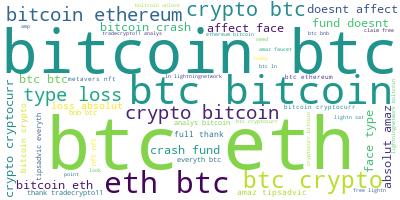

In [159]:

My_WordCloud = WordCloud(background_color="white", max_words=50)
# Join the different tweets titles together.
My_Long_String =','.join(list(df6.values))

# Generate a word cloud & visualize it
My_WordCloud.generate(My_Long_String)
My_WordCloud.to_image()

# Visualization N

In [160]:


# This code implements the concept of a Dictionary – a mapping between words and their integer ids. 
My_id2word = corpora.Dictionary(df5)

# Convert document (a list of words) into the bag-of-words format
My_Corpus = [My_id2word.doc2bow(text) for text in df5]

# Build LDA model

My_LDA = models.LdaMulticore(corpus=My_Corpus, id2word=My_id2word, num_topics=3)

#Print topics and keywords
My_LDA.print_topics()

[(0,
  '0.047*"btc" + 0.039*"bitcoin" + 0.010*"crypto" + 0.010*"eth" + 0.008*"project" + 0.007*"cryptocurr" + 0.006*"get" + 0.006*"amp" + 0.005*"price" + 0.005*"bullish"'),
 (1,
  '0.033*"btc" + 0.024*"bitcoin" + 0.023*"eth" + 0.020*"nft" + 0.019*"crypto" + 0.013*"cryptocurr" + 0.013*"nfts" + 0.012*"ethereum" + 0.011*"bnb" + 0.011*"defi"'),
 (2,
  '0.050*"bitcoin" + 0.036*"btc" + 0.020*"crypto" + 0.008*"cryptocurr" + 0.006*"buy" + 0.005*"market" + 0.005*"like" + 0.005*"time" + 0.005*"trade" + 0.004*"eth"')]

In [161]:
# Compute Coherence Score
#to get coherence value
cm = CoherenceModel(model=My_LDA, corpus=My_Corpus, coherence='u_mass')
coherence = cm.get_coherence()  # get coherence value

In [162]:

pyLDAvis.enable_notebook()

number_of_topics = 3
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(number_of_topics))

gensimvis.prepare(My_LDA, My_Corpus, My_id2word)

/Users/xinyuliu/miniforge3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/xinyuliu/miniforge3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/xinyuliu/miniforge3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/xinyuliu/miniforge3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/xinyuliu/miniforge3/lib/python3.9/site-packages/past/builtins/misc.py

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.072634  0.048658       1        1  44.813134
1      0.107541  0.012887       2        1  30.435641
0     -0.034908 -0.061545       3        1  24.751226, topic_info=          Term           Freq          Total Category  logprob  loglift
55         nft   28999.000000   28999.000000  Default  30.0000  30.0000
149        eth   39641.000000   39641.000000  Default  29.0000  29.0000
742       nfts   16354.000000   16354.000000  Default  28.0000  28.0000
6          btc  130794.000000  130794.000000  Default  27.0000  27.0000
193       defi   14568.000000   14568.000000  Default  26.0000  26.0000
...        ...            ...            ...      ...      ...      ...
10         day    2777.363822    7242.747811   Topic3  -5.7334   0.4378
51    ethereum    3233.029830   20744.490272   Topic3  -5.5814  -0.4626
32          go    2932.414484   12040.480531   Topic3  -5.6790  -0.0162
1377         1    2701.747357    6145.475705   Topic3  -5.7610   0.5745
179        buy    2800.662844   15270.643867   Topic3  -5.7250  -0.2998

[291 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
1377       1  0.353756          1
1377       2  0.206656          1
1377       3  0.439673          1
1694       1  0.074531   1000xgem
1694       2  0.803477   1000xgem
...      ...       ...        ...
23764      1  0.007648  yieldfarm
23764      2  0.951389  yieldfarm
23764      3  0.041298  yieldfarm
68081      3  0.980581     एमएलएम
68082      3  0.970631      बटकइन

[609 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

# Evaluation

In [163]:
df_enriched = df_enriched.dropna()
df_enriched.head(3)

,user_followers,user_friends,user_favourites,text,user_days_on_twitter,RiseFall,Month,Year,Hour,Processed_text,Sentiment,SVD1,SVD2,SVD3,Helpfulness
0,4082,221,59613,Another decent bounce for Bitcoin BTC\n\n1w 1d...,357,0,11,2022,17,anoth decent bounc bitcoin btc 1w 1d 8hr id sa...,0.6369,0.028673,0.075302,0.008776,14.603871
1,3771,439,11363,Heads up Ill be going live this Thursday at 18...,3647,0,11,2022,17,head ill go live thursday 1830 utc glozow shel...,0.5574,0.017790,0.048979,-0.017934,3.013259
2,19,109,132,Not too much but 2022 be good to me baby Bing ...,296,0,11,2022,17,much 2022 good babi bing bong nft ethereum bit...,0.4404,0.040933,0.076211,-0.032284,6.947368


In [164]:
df_enriched.isnull().any()
Y_train = df_enriched['RiseFall']# 获取标签值
Y_train.head()

0    0
1    0
2    0
3    0
4    0
Name: RiseFall, dtype: int64

start training.....
end training.....
accuracy= 0.699


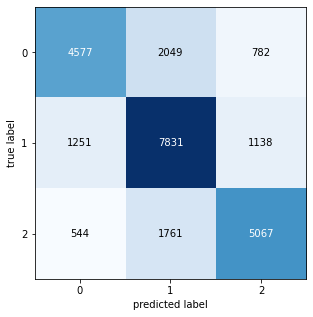

In [167]:
from tkinter import X
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer as tfidf
from nltk.corpus import stopwords
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils import shuffle
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, accuracy_score
import lightgbm as lgb
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold




import warnings
warnings.simplefilter("ignore", category=ConvergenceWarning)


def make_tfidf(reviews_bow):
    '''
    :param reviews_bow: text list
    :return: X_train
            vectorizer
    '''
    stopword = set(stopwords.words('english')) # get stop words
    vectorizer = tfidf(stop_words= stopword)
    vectorizer.fit_transform(reviews_bow)
    return vectorizer

def model_type(type):
    print('start training.....')
    if type == 'lr':
        clf = LogisticRegressionCV()
    elif type == 'nb':
        clf = MultinomialNB()
    elif type == 'svc':
        clf = LinearSVC(random_state = 42,tol=1e-5)
    elif type == 'rf':
        clf = RandomForestClassifier()
    elif type == 'pca':
        clf = PCA(n_components=3)
    elif type == 'lgb':
        params_sklearn = {
    'learning_rate':0.1,
    'max_bin':150,
    'num_leaves':32,    
    'max_depth':11,
    'reg_alpha':0.1,
    'reg_lambda':0.2,   
    'objective':'multiclass',
    'n_estimators':300,
    'num_class':3,
    #'class_weight':weight
}       
        clf = lgb.LGBMClassifier(**params_sklearn)
    
    
    return clf

if __name__=='__main__':
    # Load files into DataFrames
    X_train = df_enriched
 
    X_train = X_train.sample(100000)

    Y_train = X_train['RiseFall']# 获取标签值
    X_train.dropna()

   
    X_train_processed = X_train.drop(columns=['Processed_text','RiseFall','text'])

    X_train_processed.head(10)
    #X_submission_processed = X_submission.drop(columns=['Id', 'Summary','Score'])

    #print(len(X_submission_processed))

    #X_submission_processed['Text'] = X_submission_processed['Text'].values.astype('U')
    #print(len(X_submission_processed))

 

# initialise model and vectorizers
     
    model = model_type('lgb')



    # 切分数据集
    x_train,x_test,y_train,y_test= train_test_split(X_train_processed, Y_train,random_state= 42)


    

    model.fit(x_train,y_train)
    print('end training.....')

    
    test_result = model.predict(x_test)

    print('accuracy=',accuracy_score(y_test,test_result))
    #print(classification_report(y_test, test_result))
    #print('y_test', y_test)
    #print('pred', test_result)

    # %matplotlib inline
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    CM = confusion_matrix(y_test, test_result)
    from mlxtend.plotting import plot_confusion_matrix
    fig, ax = plot_confusion_matrix(conf_mat=CM , figsize=(10, 5))
    plt.show()

    # Predict the score using the model
    #print(len(X_submission_processed))
    #X_submission['Score'] = pipe.predict(X_submission_processed)
    # Create the submission file
    #submission = X_submission[['Id', 'Score']]
    #submission.to_csv("./data/submission.csv", index=False)
